### import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from tpot import TPOTRegressor

In [2]:
%matplotlib inline

### Placing modules on path and importing

In [3]:
curr_dir = os.getcwd()
parent_dir = os.path.split(curr_dir)[0]
sys.path.append(parent_dir)

In [4]:
from EDA import ExploratoryDataAnalysis
from metrics import get_metrics
from metrics import show_residual, show_actual_vs_prediction_plot

### Read data

In [5]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")

### Exploratory Data Analysis

##### selected columns for ML model

In [6]:
sel_cols = ['CNC', 'HRD', 'HRM', 'GR', 'ZDEN']

##### function for EDA on training dataset

In [7]:
def eda_processing(df, output1, output2, sel_cols):
    cols = sel_cols + ['DTC', 'DTS']
    
    eda = ExploratoryDataAnalysis()    
    df = eda.convert_missing_to_null(df, missing_value=-999)
    
    """ basic EDA """
    eda.describe_data(df)
    """ EDA plots """
    eda.exploratory_plots(df)
    
    df = df[cols]    
    
    df.dropna(inplace=True)    
    
    y2 = df[output2]
    df = df.drop([output2], axis=1)    
    X = df.drop([output1], axis=1)
    y1 = df[output1]
    Xy1 = pd.concat([X, y1], axis=1)
    
    return X, y1, Xy1, y2

##### function for splitting train.csv data into train and dev sets

In [8]:
def preprocessing(X, y1, y2):
    
    X_train, X_dev, y1_train, y1_dev = train_test_split(X, y1, test_size = 0.2, random_state = 0)
    X_train, X_dev, y2_train, y2_dev = train_test_split(X, y2, test_size = 0.2, random_state = 0)
    Xy1_train = pd.concat([X_train, y1_train], axis=1)
    Xy1_dev = pd.concat([X_dev, y1_dev], axis=1)
    Xy1_train_dev = pd.concat([Xy1_train, Xy1_dev], axis=0)

    return X_train, y1_train, X_dev, y1_dev, Xy1_train, Xy1_dev, Xy1_train_dev, y2_train, y2_dev

##### function for EDA on test.csv

In [9]:
def eda_processing_test(df_test, sel_cols):
    
    eda = ExploratoryDataAnalysis()    
    df_test = eda.convert_missing_to_null(df_test, missing_value=-999)
    
    """ basic EDA """
    eda.describe_data(df)
    """ EDA plots """
    eda.exploratory_plots(df)
    
    df_test = df_test[sel_cols]    
    X_test = df_test.dropna()
    
    return X_test

In [10]:
outputs = ["DTC", "DTS"]
output1 = "DTC" # The output column we want to keep in the df
output2 = list(set(outputs).difference(set([output1])))[0] # the second output column

#### EDA on train.csv

********** shape of dataframe is **************:
 (30143, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     29633 non-null  float64
 1   CNC     29408 non-null  float64
 2   GR      29889 non-null  float64
 3   HRD     29758 non-null  float64
 4   HRM     29758 non-null  float64
 5   PE      29464 non-null  float64
 6   ZDEN    29462 non-null  float64
 7   DTC     26089 non-null  float64
 8   DTS     25278 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB
********** dataframe info is **********:
 None
************** dataframe column stats are **************:
                 CAL           CNC            GR           HRD           HRM  \
count  29633.000000  29408.000000  29889.000000  29758.000000  29758.000000   
mean       8.654281      0.683437     47.780541     16.953912     14.492077   
std        1.749145     30.689679     51

C:\Users\YAORUGAN\AppData\Local\Continuum\anaconda3\envs\spwla_env\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


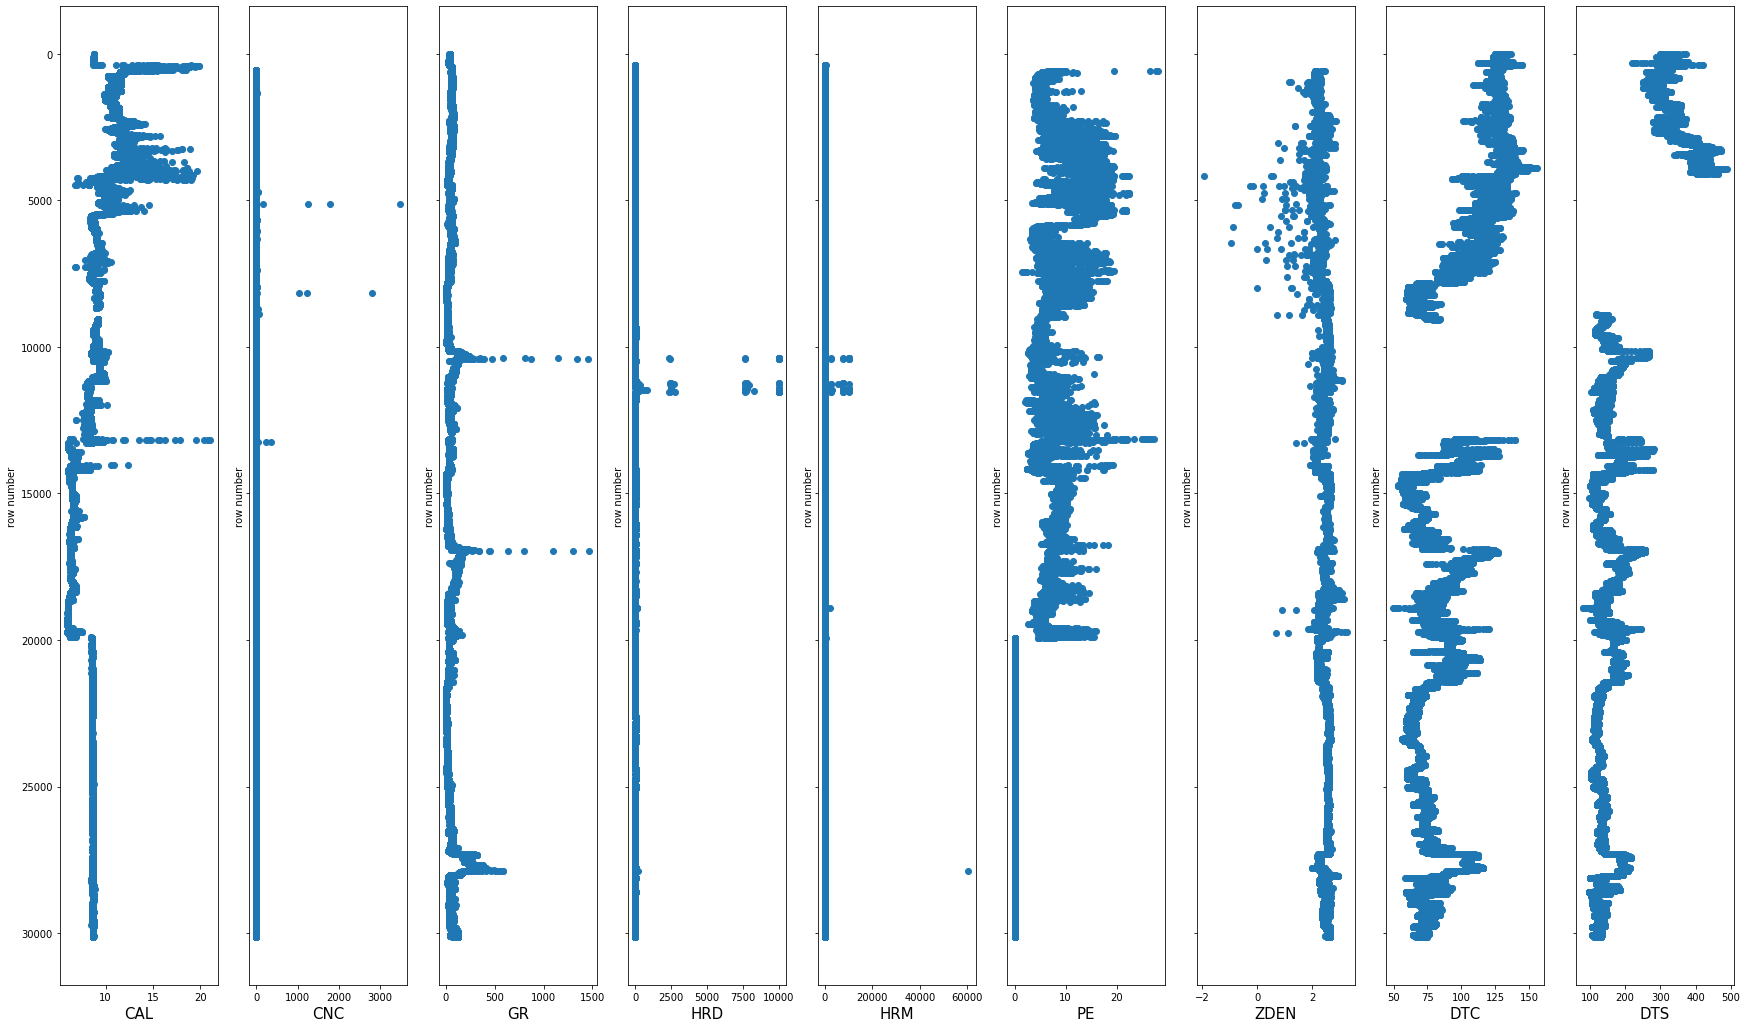

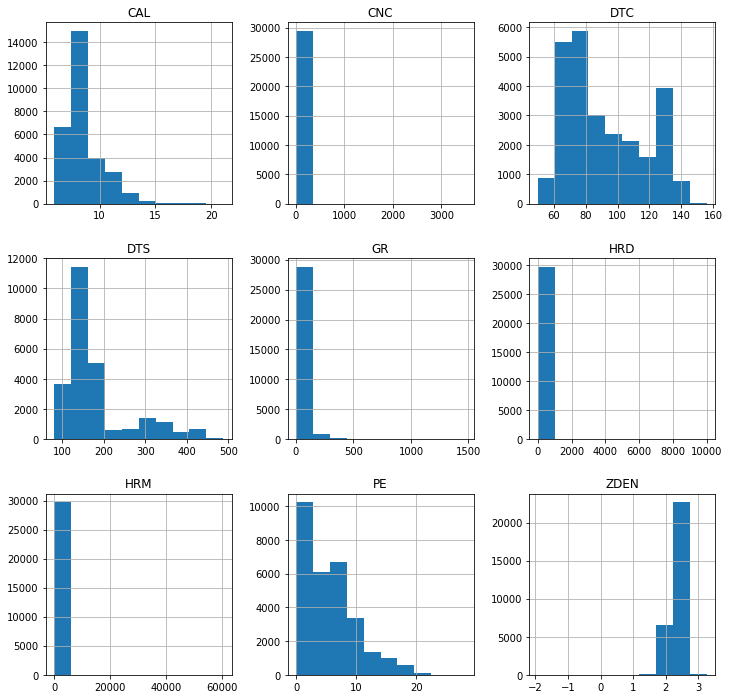

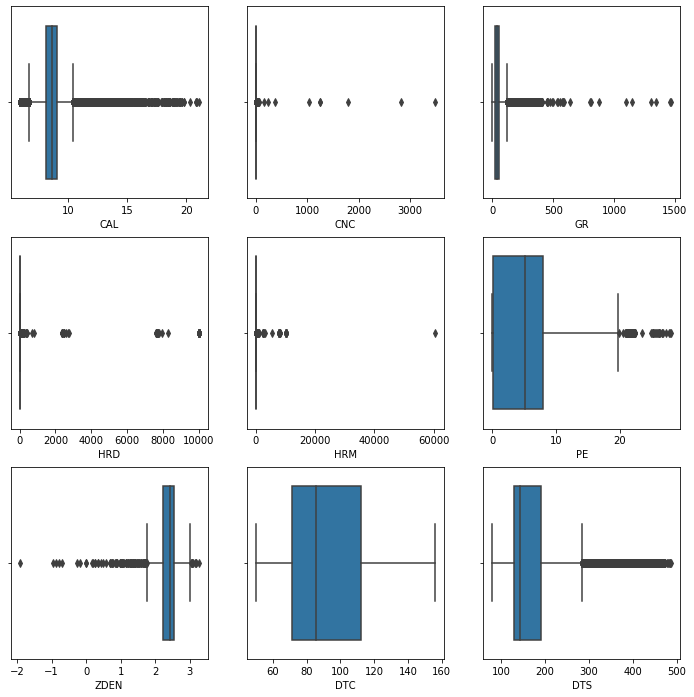

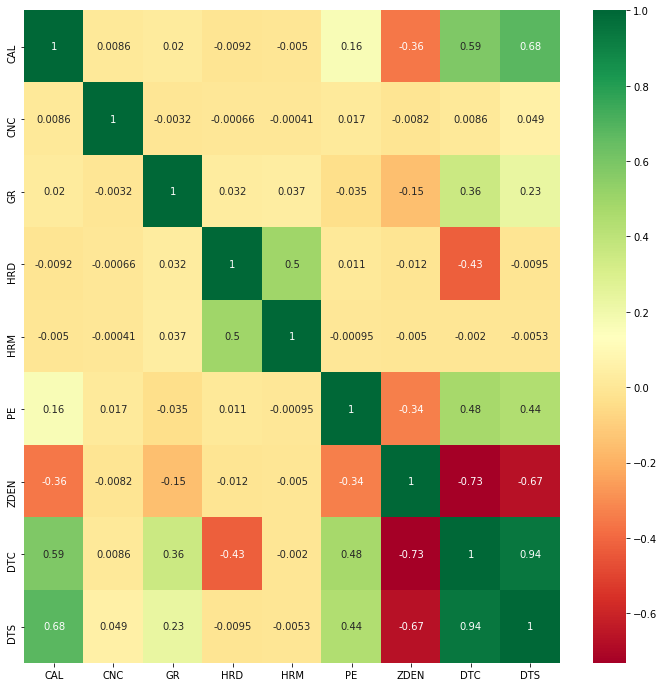

In [11]:
X, y1, Xy1, y2 = eda_processing(df, output1, output2, sel_cols)
X_train, y1_train, X_dev, y1_dev, Xy1_train, Xy1_dev, Xy1_train_dev, y2_train, y2_dev = preprocessing(X, y1, y2)

#### EDA on test.csv

********** shape of dataframe is **************:
 (30143, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     29633 non-null  float64
 1   CNC     29408 non-null  float64
 2   GR      29889 non-null  float64
 3   HRD     29758 non-null  float64
 4   HRM     29758 non-null  float64
 5   PE      29464 non-null  float64
 6   ZDEN    29462 non-null  float64
 7   DTC     26089 non-null  float64
 8   DTS     25278 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB
********** dataframe info is **********:
 None
************** dataframe column stats are **************:
                 CAL           CNC            GR           HRD           HRM  \
count  29633.000000  29408.000000  29889.000000  29758.000000  29758.000000   
mean       8.654281      0.683437     47.780541     16.953912     14.492077   
std        1.749145     30.689679     51

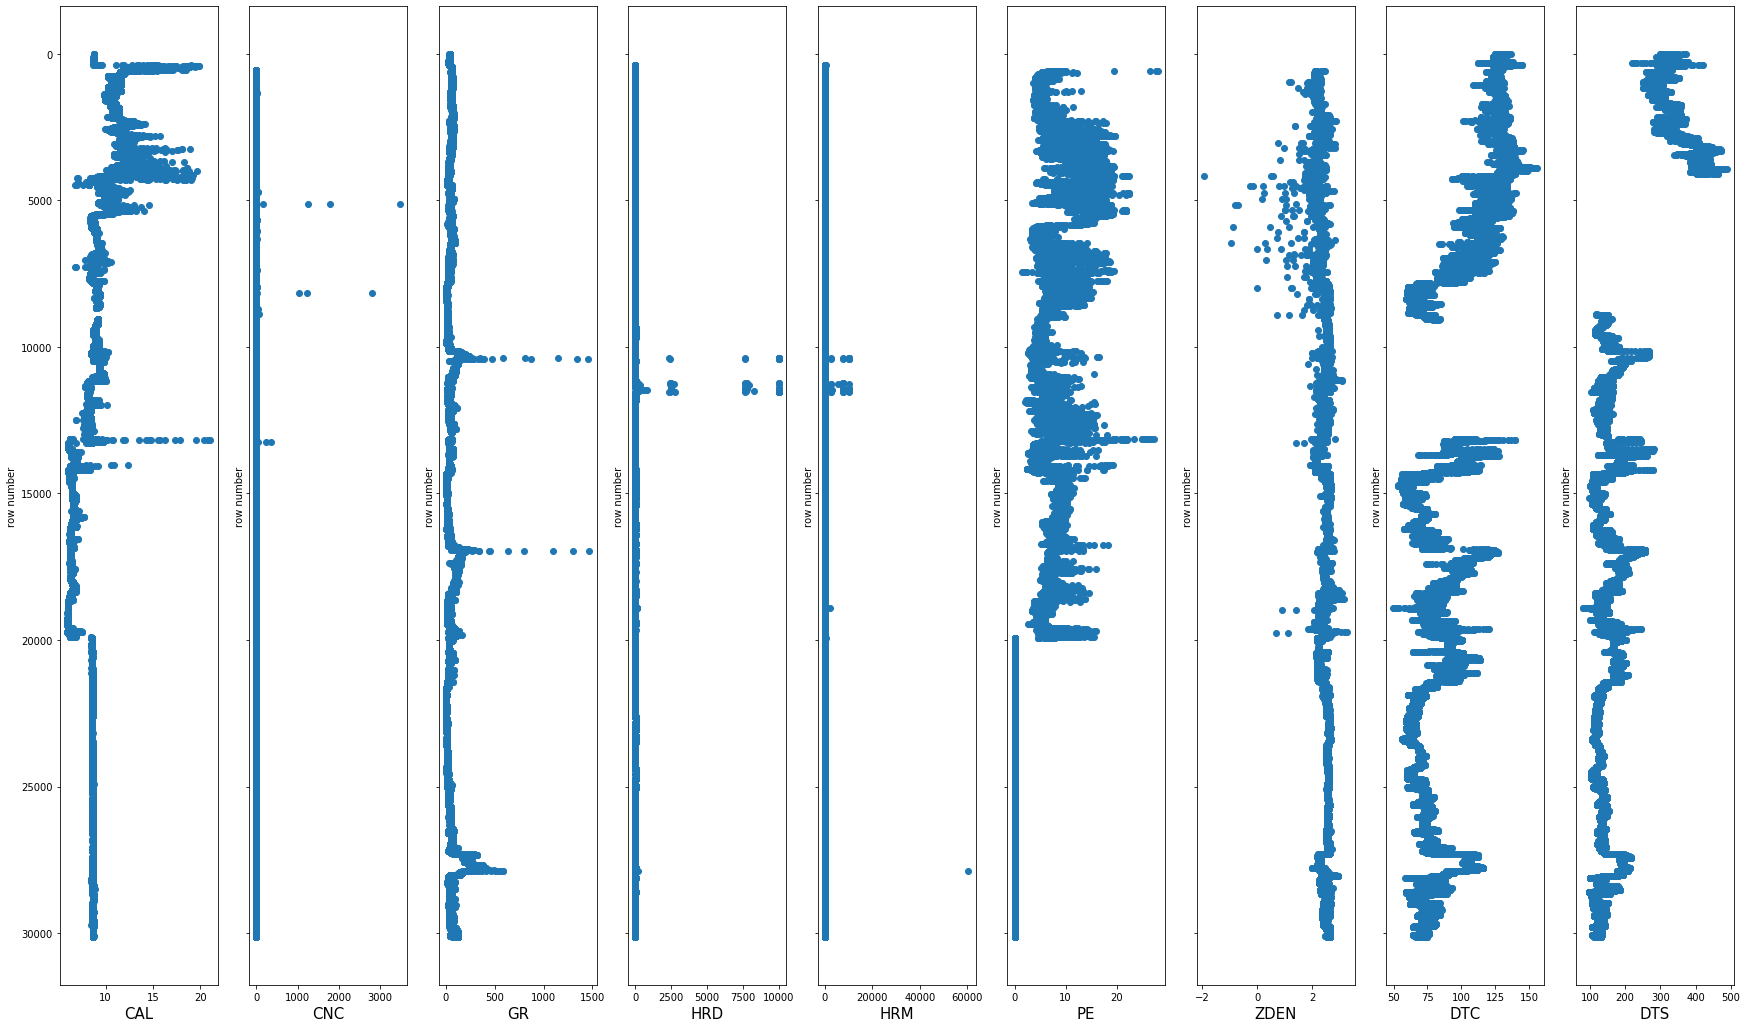

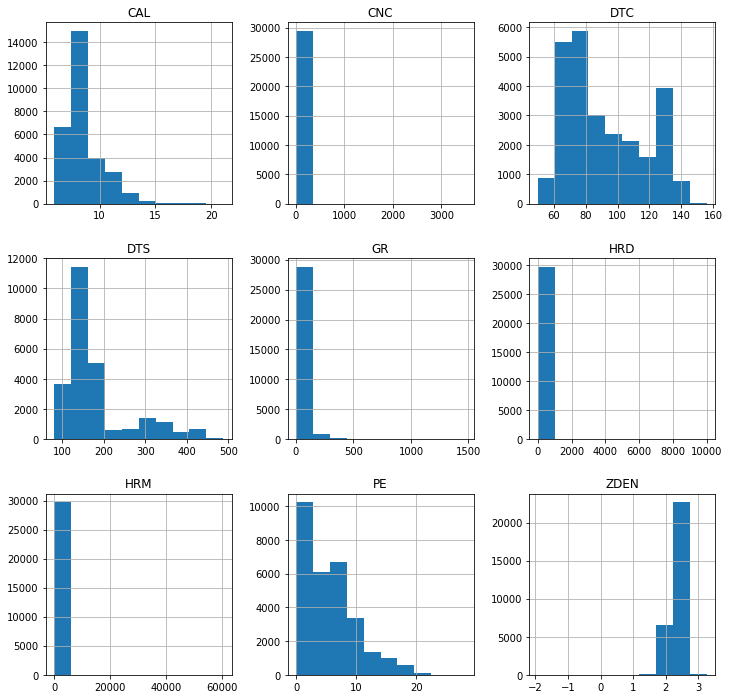

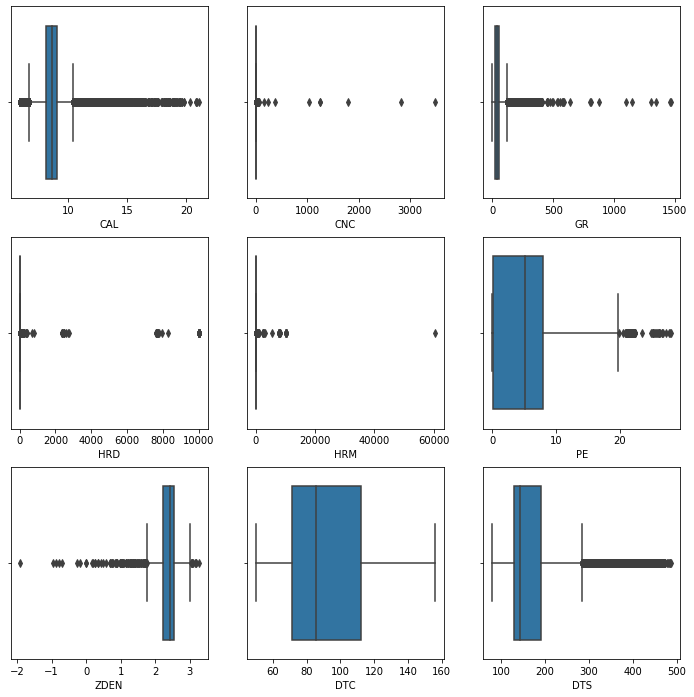

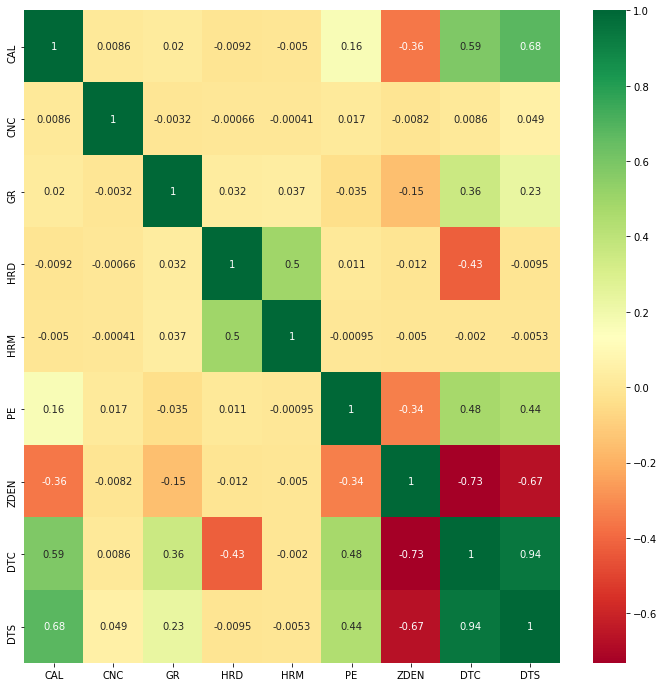

In [12]:
X_test = eda_processing_test(df_test, sel_cols)

### TPOT

In [13]:
# name of pickle file to write TPOT model to
fname = 'tpot_base_featsel_DTC.pickle'
# directory to write pickle file to
tpot_pickle_dir = "tpot_pickle_models"

##### TPOT model training

In [14]:
cv = 10

metric = "neg_mean_squared_error" #['neg_median_absolute_error', 'neg_mean_absolute_error',
                                              #'neg_mean_squared_error', 'r2']

seed = 42
pre = True # for training
post = True # for evaluation

In [ ]:
if pre:
    tpot = TPOTRegressor(generations=5, population_size=100, verbosity=2, random_state=seed, cv=cv, periodic_checkpoint_folder='./intermediate_results/')
    tpot.fit(X_train, y1_train)
    best_model = tpot.fitted_pipeline_

##### Writing best model to pickle file

In [23]:
if not os.path.exists(tpot_pickle_dir):
    os.mkdir(tpot_pickle_dir)
fpath = os.path.join(tpot_pickle_dir, fname)
pickle.dump(best_model, open(fpath, "wb"))

##### loading model from pickle file (use this if you have a pickle model)

In [ ]:
fpath = os.path.join(tpot_pickle_dir, fname)
best_model = pickle.load(open(fpath, "rb"))

### Best model predictions and metrics

In [24]:
def predictions_metrics(best_model, X_train, y1_train, X_dev, y1_dev, X_test, output):
    y1_train_pred = best_model.predict(X_train)
    y1_train_pred = pd.Series(y1_train_pred, name=str(output + "_y_pred"), index=X_train.index)
    
    y1_dev_pred = best_model.predict(X_dev)    
    y1_dev_pred = pd.Series(y1_dev_pred, name=str(output + "_y_pred"), index=X_dev.index)
    
    train_flag = pd.Series(["train"]*X_train.shape[0], name="train_dev_flag", index=X_train.index)
    dev_flag = pd.Series(["dev"]*X_dev.shape[0], name="train_dev_flag", index=X_dev.index)

    y1_test_pred = best_model.predict(X_test)    
    y1_test_pred = pd.Series(y1_test_pred, name=str(output + "_y_pred"), index=X_test.index)
    
    Xy1_train_pred = pd.concat([X_train, y1_train, y1_train_pred, train_flag], axis=1)
    Xy1_dev_pred = pd.concat([X_dev, y1_dev, y1_dev_pred, dev_flag], axis=1) # this is the independent test set from splitting train.csv
    Xy1_train_dev_pred = pd.concat([Xy1_train_pred, Xy1_dev_pred], axis=0)
    Xy1_test_pred = pd.concat([X_test, y1_test_pred], axis=1) # This is the independent test set from test.csv
    
    print(get_metrics(y1_train, y1_train_pred))
    print(get_metrics(y1_dev, y1_dev_pred))
    
    return Xy1_train_pred, y1_train_pred, Xy1_dev_pred, y1_dev_pred, Xy1_train_dev_pred, Xy1_test_pred, y1_test_pred

In [25]:
Xy1_train_pred, y1_train_pred, Xy1_dev_pred, y1_dev_pred, Xy1_train_dev_pred, \
Xy1_test_pred, y1_test_pred = predictions_metrics(best_model, X_train, y1_train, X_dev, y1_dev, X_test, output1)

root_mean_squared_error               2.822810
normalized_root_mean_squared_error    0.031995
neg_mean_squared_error               -7.968256
root mean squared log error           0.030018
mean absolute percentage error        1.773443
r2_score                              0.985530
mean_absolute_error                   1.570092
explained_variance                    0.985530
dtype: float64
root_mean_squared_error                3.492773
normalized_root_mean_squared_error     0.039635
neg_mean_squared_error               -12.199466
root mean squared log error            0.037400
mean absolute percentage error         2.238220
r2_score                               0.977976
mean_absolute_error                    1.976467
explained_variance                     0.977976
dtype: float64


### Saving the predictions

In [26]:
fname_prefix = "tpot_base_featsel"
output_fname1 = fname_prefix + "_DTC_train_dev.csv"
output_fname2 = fname_prefix + "_DTC_test.csv"
output_fname3 = fname_prefix + "_DTS_train_dev.csv"
output_fname4 = fname_prefix + "_DTS_test.csv"

In [27]:
if output1 == "DTC":    
    output_fname_train_dev = output_fname1
    output_fname_test = output_fname2
elif output1 == "DTS":
    output_fname_train_dev = output_fname3
    output_fname_test = output_fname4
Xy1_train_dev_pred.to_csv(output_fname_train_dev)
Xy1_test_pred.to_csv(output_fname_test)

### Plots

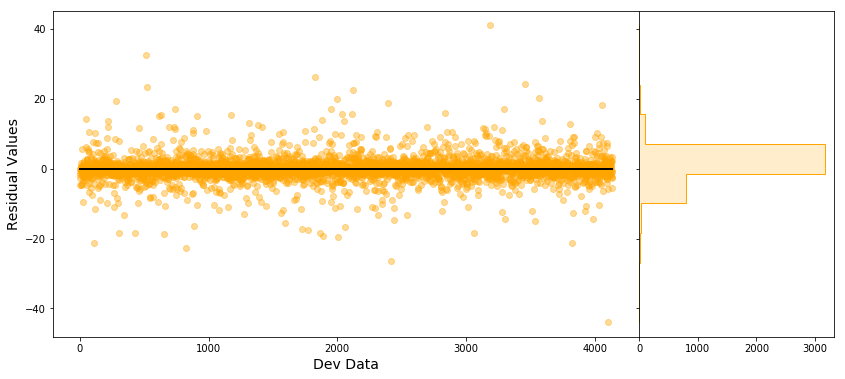

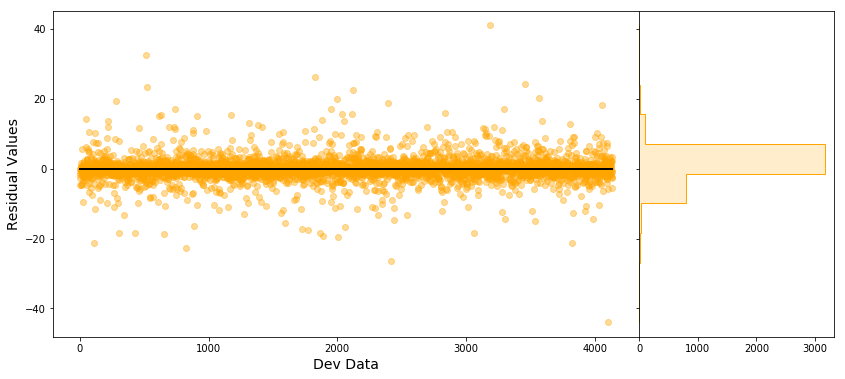

In [28]:
show_residual(y1_dev_pred.values-y1_dev.values, 'Dev Data', 'orange')

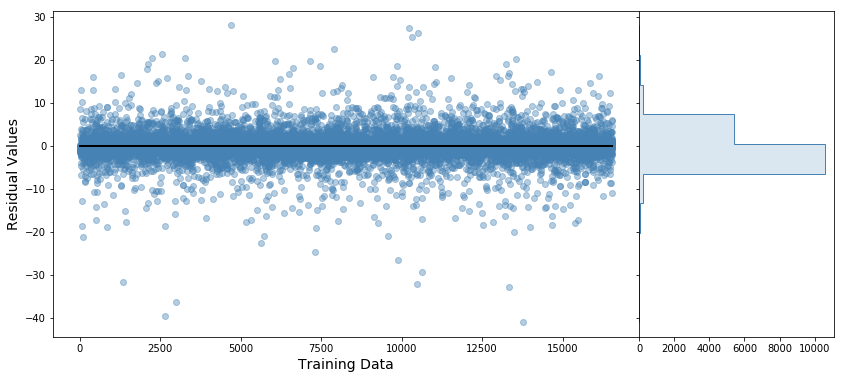

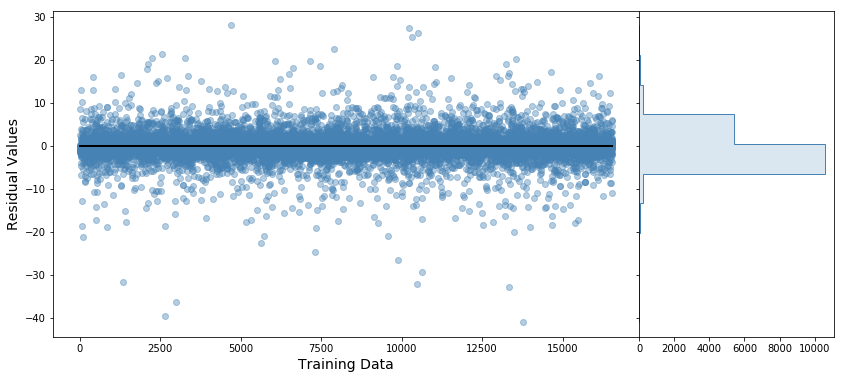

In [29]:
show_residual(y1_train_pred.values-y1_train.values, 'Training Data', 'steelblue')

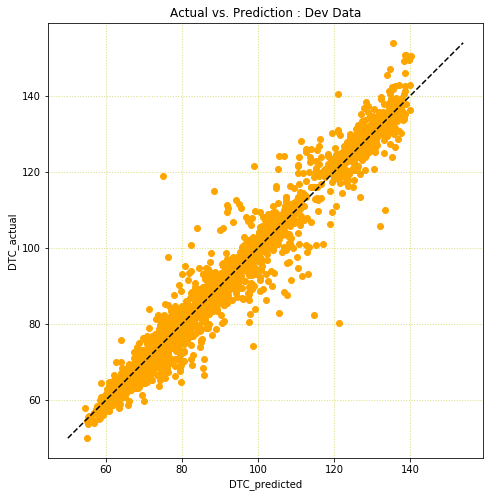

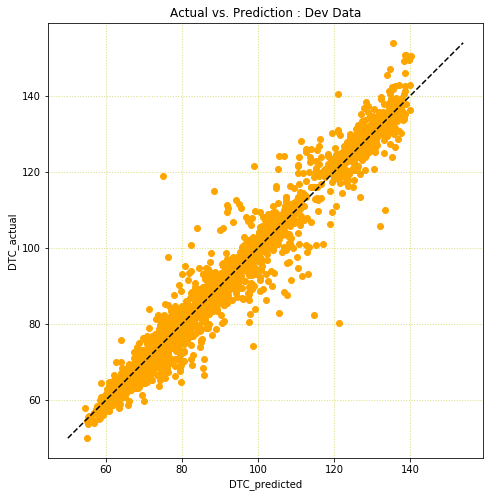

In [30]:
show_actual_vs_prediction_plot(y1_dev_pred, y1_dev, 'DTC', 'Dev Data')

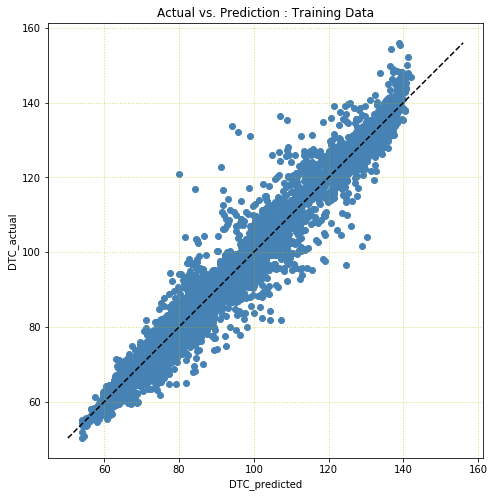

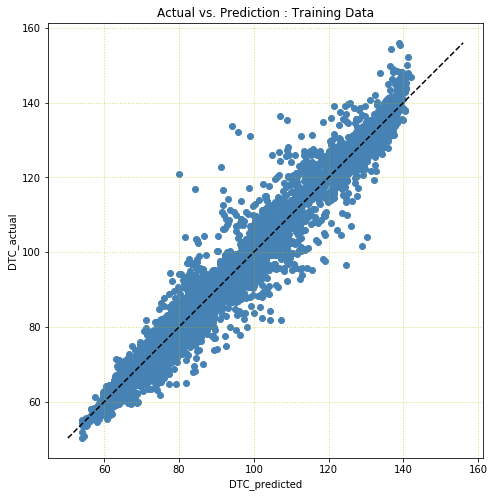

In [31]:
show_actual_vs_prediction_plot(y1_train_pred, y1_train, 'DTC', 'Training Data')

### Calculating combined RMSE of DTC and DTS predictions

##### read results from csv for DTC and DTS

In [ ]:
def combined_rmse(yc_dev, yc_dev_pred, ys_dev, ys_dev_pred):
    m = yc_dev.shape[0]
    _combined_rmse = (0.5 * (1/m) * (np.sum((yc_dev-yc_dev_pred)**2) + np.sum((ys_dev-ys_dev_pred)**2)))**0.5
    return _combined_rmse

##### filenames of files with DTC and DTS prediction results

In [1]:
fname_prefix_DTC_model = "tpot_base_featsel_outrem"
fname_prefix_DTS_model = "lgbm_base_featsel_outrem"
output_fname1 = fname_prefix_DTC_model + "_DTC_train_dev.csv"
output_fname2 = fname_prefix_DTC_model + "_DTC_test.csv"
output_fname3 = fname_prefix_DTS_model + "_DTS_train_dev.csv"
output_fname4 = fname_prefix_DTS_model + "_DTS_test.csv"

##### read results from csv for DTC and DTS and return combined RMSE of dev set

In [ ]:
try:
    """ read results from csv for DTC and DTS """
    X_DTC_train_dev = pd.read_csv(output_fname1, index_col=0)
    X_DTC_test_dev = pd.read_csv(output_fname2, index_col=0)
    X_DTS_train_dev = pd.read_csv(output_fname3, index_col=0)
    X_DTS_test_dev = pd.read_csv(output_fname4, index_col=0)
    
    yc_dev = X_DTC_train_dev.loc[X_DTC_train_dev["train_dev_flag"]=="dev", "DTC"]
    yc_dev_pred = X_DTC_train_dev.loc[X_DTC_train_dev["train_dev_flag"]=="dev", "DTC_y_pred"]
    ys_dev = X_DTS_train_dev.loc[X_DTS_train_dev["train_dev_flag"]=="dev", "DTS"]
    ys_dev_pred = X_DTS_train_dev.loc[X_DTS_train_dev["train_dev_flag"]=="dev", "DTS_y_pred"]

    _combined_rmse = combined_rmse(yc_dev, yc_dev_pred, ys_dev, ys_dev_pred)
    print(f"combined rmse is: {_combined_rmse}")
except Exception as e:
    print("both yc_test_pred and ys_test_pred need to be present")
    print(e)

# combine DTS and DTC for submission

In [36]:
import pandas as pd
dtc = "tpot_base_featsel_DTC_test.csv"

dts = "lgbm_base_featsel_DTS_test.csv"

In [37]:
d_dtc = pd.read_csv(dtc)
d_dts = pd.read_csv(dts)

In [38]:
len(d_dtc), len(d_dts)

(11088, 11088)

In [39]:
DTC = d_dtc['DTC_y_pred']
DTS = d_dts['DTS_y_pred']
len(DTC), len(DTS)

(11088, 11088)

In [40]:
final = pd.concat([DTC, DTS], axis=1)
len(final)

11088

In [41]:
final.head()

DTC_y_pred  DTS_y_pred
0  101.975777  234.610923
1  102.726045  231.356172
2  109.687830  237.014904
3  109.567982  221.521094
4  109.437455  214.173287

In [42]:
final = final.rename(columns={"DTC_y_pred": "DTC", "DTS_y_pred": "DTS"}, errors="raise")
len(final)

11088

In [43]:
final.head()

DTC         DTS
0  101.975777  234.610923
1  102.726045  231.356172
2  109.687830  237.014904
3  109.567982  221.521094
4  109.437455  214.173287

In [44]:
final.to_csv('MSArchie_3.csv', index=False)